In [1]:
!pip install --upgrade protobuf

In [2]:
#Library Imports
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
labels = []
img_names = []
img_paths = []
gender = []
path = '../data/NistFormatted/'
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file), 'r') as t:
            content = t.readlines()
            gender.append(content[0].rsplit(' ')[1][0])
            img_name = content[2].rsplit(' ')[1][:-4] + '.png'
            img_paths.append(os.path.join(path,img_name))
            img_names.append(img_name)
            labels.append((content[1].rsplit(' ')[1][0]))           
df = pd.DataFrame()
df['IMAGE PATH'] = img_paths
df['IMAGE NAME'] = img_names
df['LABEL'] = labels
df['GENDER'] = gender

In [4]:
df.head()

,IMAGE PATH,IMAGE NAME,LABEL,GENDER
0,../data/NistFormatted/f0001_01.png,f0001_01.png,W,M
1,../data/NistFormatted/f0002_05.png,f0002_05.png,R,M
2,../data/NistFormatted/f0003_10.png,f0003_10.png,L,F
3,../data/NistFormatted/f0004_05.png,f0004_05.png,R,M
4,../data/NistFormatted/f0005_03.png,f0005_03.png,A,M


In [5]:
#Classes to integer mapping
classes = list(np.unique(labels))
print(classes)
map_classes = dict(zip(classes, [t for t in range(len(classes))]))
print(map_classes)
df['MAPPED LABELS'] = [map_classes[i] for i in df['LABEL']]
df = df.sample(frac = 1) #To randomly shuffle the data
df.to_csv('dataset.csv')
df.head()

['A', 'L', 'R', 'T', 'W']
{'A': 0, 'L': 1, 'R': 2, 'T': 3, 'W': 4}


,IMAGE PATH,IMAGE NAME,LABEL,GENDER,MAPPED LABELS
3646,../data/NistFormatted/s1647_02.png,s1647_02.png,A,F,0
657,../data/NistFormatted/f0658_09.png,f0658_09.png,W,F,4
2923,../data/NistFormatted/s0924_09.png,s0924_09.png,L,M,1
184,../data/NistFormatted/f0185_05.png,f0185_05.png,R,M,2
1807,../data/NistFormatted/f1808_06.png,f1808_06.png,A,M,0


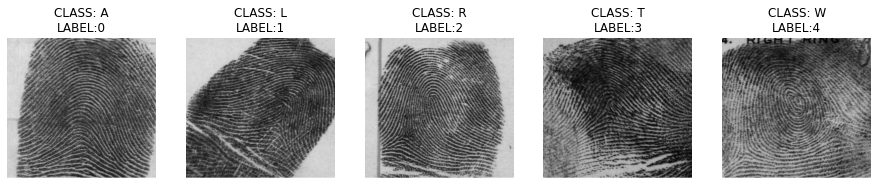

In [6]:
dim = len(classes)
fig,axes = plt.subplots(1,dim) 
fig.subplots_adjust(0,0,2,2)
for idx, i in enumerate(classes):
    dum = df[df['LABEL'] == i]
    random_num = random.choice(dum.index)
    label = df.loc[random_num]['LABEL']
    axes[idx].imshow(cv2.imread(df.loc[random_num]['IMAGE PATH']))
    axes[idx].set_title("CLASS: "+label +"\n" +  "LABEL:"+str(map_classes[label]))
    axes[idx].axis('off')

In [7]:
X_data = df['IMAGE PATH']
y_data = df['MAPPED LABELS']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, test_size=0.01,stratify=y_data)
#Creating numpy arrays of images
X = []
y = []
for i in X_train:
    X.append(cv2.imread(i))
for i in y_train:
    y.append(i)
X = np.array(X)
y = np.array(y)
# Converting the labels vector to one-hot format
y = keras.utils.to_categorical(y, 5)
print(f"Total number of Images: {len(X_data)}")
print(f"Number of Training Images: {len(X_train)}")
print(f"Number of Test Images: {len(X_test)}") # Saving a small number of images for model testing
print(f"Shape of Images: {X[0].shape}") #Printing the shape of Images

Total number of Images: 4000
Number of Training Images: 3960
Number of Test Images: 40
Shape of Images: (512, 512, 3)


In [10]:
model = keras.Sequential(
    [
        layers.Conv2D(32, input_shape=(512,512,3),padding="same",kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3),padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(5, activation="softmax",kernel_regularizer='l1_l2'),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)       

In [ ]:
#Training
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X, y=y, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
50/50 [==============================] - 628s 12s/step - loss: 9.6575 - accuracy: 0.1960 - val_loss: 5.7869 - val_accuracy: 0.2159
Epoch 2/20
50/50 [==============================] - 584s 12s/step - loss: 5.4120 - accuracy: 0.2282 - val_loss: 5.0377 - val_accuracy: 0.2588
Epoch 3/20
50/50 [==============================] - 571s 11s/step - loss: 4.7371 - accuracy: 0.2841 - val_loss: 4.3855 - val_accuracy: 0.3624
Epoch 4/20
50/50 [==============================] - 625s 12s/step - loss: 4.0618 - accuracy: 0.4116 - val_loss: 3.5666 - val_accuracy: 0.5732
Epoch 5/20
50/50 [==============================] - 614s 12s/step - loss: 3.4423 - accuracy: 0.5338 - val_loss: 3.0945 - val_accuracy: 0.5909
Epoch 6/20
50/50 [==============================] - 603s 12s/step - loss: 2.9634 - accuracy: 0.5830 - val_loss: 2.7008 - val_accuracy: 0.6477
Epoch 7/20
50/50 [==============================] - 606s 12s/step - loss: 2.6087 - accuracy: 0.6029 - val_loss: 2.3567 - val_accuracy: 0.6629
Epoch 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='center right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
fig,axes = plt.subplots(5,5) 
fig.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        num = random.randint(0,len(test_X)-1)
        display_image = test_X[num].squeeze(0)
        image = test_X[num]
        predicted_prob = model.predict(image)
        predicted_class = np.argmax(predicted_prob)
        ground_truth =classes[y_test.iloc[num]]
        axes[i,j].imshow(display_image)
        axes[i,j].imshow(display_image)
        if(classes[predicted_class] != classes[y_test.iloc[num]]):
            t = 'PREDICTED {} \n GROUND TRUTH[{}]'.format(classes[predicted_class], classes[y_test.iloc[num]])
            axes[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[CORRECT] {}'.format(classes[predicted_class]) 
            axes[i,j].set_title(t)
        axes[i,j].axis('off')